# Uber Fares Dataset - Feature Engineering and Data Scaling 
In this third notebook, we have two aims:
1) Feature Engineering to deal with datetime and latitude/longitude features;
2) Scaling some features to facilitate the predictions in the future.

## Imports 

In [1]:
# basic libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from math import radians

# modeling libraries 
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Loading the data 

In [2]:
root_path = '../../uber-fares-prediction/data/processed/'

# train set 
X_train_uber = (
    pd.read_csv(
        root_path + 'uber_train_set.csv'
    )
)

# validation set 
X_test_uber = (
    pd.read_csv(
        root_path + 'uber_validation_set.csv'
    )
)

## Feature Engineering

The feature engineering process for this dataset is very interesting. First we will dealing with datetime variables. Next, we will dealing with latitude and longitude features. 

## Date Features

Let us first deal with `pickup_datetime` column splitting into a `date` and a `time` column. It is important to keep in mind that machine learning models do not know how to work with datetime variables. A good way to deal with these variables is to use its information - day, month and year - and use this values as integers values.

In [3]:
# changing pickup_datetime to a datetime variable

# train set 
X_train_uber.pickup_datetime = (
    pd.to_datetime(X_train_uber.pickup_datetime)
)

# validation set 
X_test_uber.pickup_datetime = (
    pd.to_datetime(X_test_uber.pickup_datetime)
)

We will create four features. The first one is `pickup_day`, which represents the day present on `pickup_datetime`. The second feature is `pickup_month`, which represents the month present on `pickup_datetime`. The third feature is `pickup_year`, which represents the year present on `pickup_datetime`. Lastly, the fourth feature is regarding to the hour of the ride, which also is an information present on `pickup_datetime`.

In [4]:
# creating four features: pickup_year, pickup_month, pickup_day and pickup_hour

# train set 
X_train_uber = (
    X_train_uber
    .assign(
        pickup_day = X_train_uber.pickup_datetime.dt.day,
        pickup_month = X_train_uber.pickup_datetime.dt.month,
        pickup_year = X_train_uber.pickup_datetime.dt.year,
        pickup_hour = X_train_uber.pickup_datetime.dt.hour
    )
)

# validation set 
X_test_uber = (
    X_test_uber
    .assign(
        pickup_day = X_train_uber.pickup_datetime.dt.day,
        pickup_month = X_train_uber.pickup_datetime.dt.month,
        pickup_year = X_train_uber.pickup_datetime.dt.year,
        pickup_hour = X_train_uber.pickup_datetime.dt.hour
    )
)

In [5]:
# dropping pickup_datetime variable 

X_train_uber = (
    X_train_uber
    .drop(
        columns=['pickup_datetime']
    )
)

X_test_uber = (
    X_test_uber
    .drop(
        columns=['pickup_datetime']
    )
)

Let us see if there are hours in which we have a higher number of rides:

Text(0, 0.5, 'Amount of Rides')

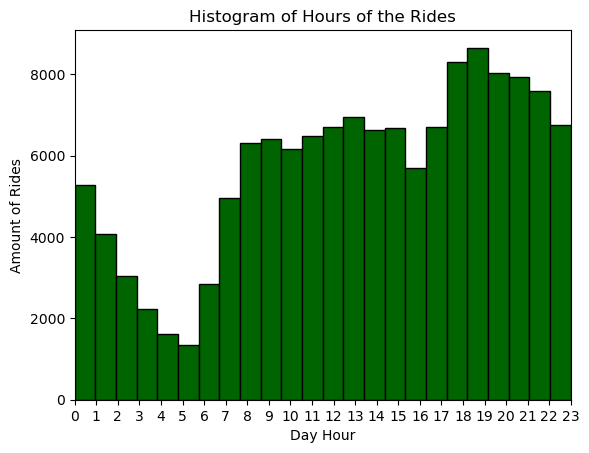

In [6]:
# histogram - hours of the rides 
plt.hist(
    X_train_uber['pickup_hour'], 
    color = 'darkgreen', 
    edgecolor = 'black',
    bins = 24
)
plt.xlim(0,23)
tick_interval = 1
plt.xticks(range(0, 24, tick_interval))
plt.title('Histogram of Hours of the Rides')
plt.xlabel('Day Hour')
plt.ylabel('Amount of Rides')

As expected, the rush time (18-19hrs) contains more rides in comparison to the other hours. We also can see the quantity of rides by year and by month of the year:

Text(0.5, 1.0, 'Count Plot of Rides by Year')

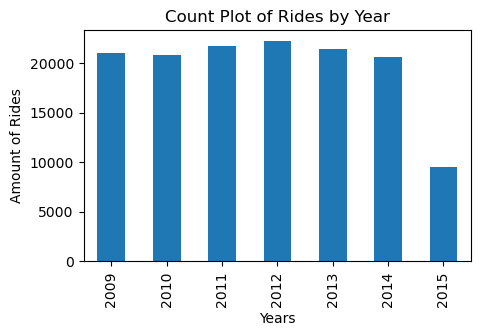

In [7]:
# amount of rides by year 
plt.figure(figsize=(5,3))
X_train_uber.pickup_year.value_counts().sort_index().plot(kind='bar')
plt.xlabel("Years")
plt.ylabel("Amount of Rides")
plt.title("Count Plot of Rides by Year")

Text(0.5, 1.0, 'Count Plot of Rides by Month')

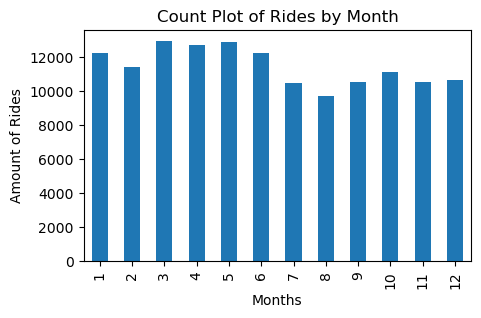

In [8]:
# amount of rides by month 
plt.figure(figsize=(5,3))
X_train_uber.pickup_month.value_counts().sort_index().plot(kind='bar')
plt.xlabel("Months")
plt.ylabel("Amount of Rides")
plt.title("Count Plot of Rides by Month")

The distribution of rides by year is almost uniform except by $2015$ when we do not have data posterior to June. The distribution of rides by month shows a major presence of rides in the first semester of the year.

## Latitude and Longitude Features - Haversine Distance 

Our goal now is to create a distance (in km) feature based on latitude and longitude ones. To do that, we will use Haversine Distance, which is the angular distance between two points on the surface of a sphere. First we need to transform the latitude and longitude coordinates into radians. 

### Calculating distance (in km) from latitude and longitude features

The first step is to transform latitude and longitude features from degrees to radians:

In [9]:
# transforming latitude and longitude features from degrees to radians

# train set 
X_train_uber = (
    X_train_uber
    .assign(
        pickup_latitude = lambda df_: df_["pickup_latitude"].apply(lambda x: radians(x)),
        pickup_longitude = lambda df_: df_["pickup_longitude"].apply(lambda x: radians(x)),
        dropoff_latitude = lambda df_: df_["dropoff_latitude"].apply(lambda x: radians(x)),
        dropoff_longitude = lambda df_: df_["dropoff_longitude"].apply(lambda x: radians(x))
    )
)

# validation set 
X_test_uber = (
    X_test_uber
    .assign(
        pickup_latitude = lambda df_: df_["pickup_latitude"].apply(lambda x: radians(x)),
        pickup_longitude = lambda df_: df_["pickup_longitude"].apply(lambda x: radians(x)),
        dropoff_latitude = lambda df_: df_["dropoff_latitude"].apply(lambda x: radians(x)),
        dropoff_longitude = lambda df_: df_["dropoff_longitude"].apply(lambda x: radians(x))
    )
)

To create the distance (in km) from latitude and longitude features, we will make use of `haversine_distances` from Scikit-learn. To use this function, it is necessary to pass a list of lists, where the first list is the first point coordinates (latitude/longitude, in radians) and the second list consists the coordinates of the second point (latitude/longitude, in radians). In our case, these coordinates are `pickup_longitude` and `pickup_latitude` for the first point, and `dropoff_longitude` and `dropoff_latitude` for the second point. 

In [10]:
# joining latitude and longitude for pickup and dropoff coordinates

# train set 
pickup_coordinates_X_train = [
    coordinates for coordinates in zip(X_train_uber["pickup_latitude"], X_train_uber["pickup_longitude"])
]
dropoff_coordinates_X_train = [
    coordinates for coordinates in zip(X_train_uber["dropoff_latitude"], X_train_uber["dropoff_longitude"])
]

# validation set 
pickup_coordinates_X_test = [
    coordinates for coordinates in zip(X_test_uber["pickup_latitude"], X_test_uber["pickup_longitude"])
]
dropoff_coordinates_X_test = [
    coordinates for coordinates in zip(X_test_uber["dropoff_latitude"], X_test_uber["dropoff_longitude"])
]

In [11]:
# creating a list of lists to be used on haversine_distances 

# train set 
pickup_coordinates_list_X_train = pd.DataFrame(pickup_coordinates_X_train).values.tolist()
dropoff_coordinates_list_X_train = pd.DataFrame(dropoff_coordinates_X_train).values.tolist()

# validation set 
pickup_coordinates_list_X_test = pd.DataFrame(pickup_coordinates_X_test).values.tolist()
dropoff_coordinates_list_X_test = pd.DataFrame(dropoff_coordinates_X_test).values.tolist()

Now we can obtain the haversine distances list and include this list as a column in our dataframe:

In [12]:
# haversine distances list in kilometers

# train set 
haversine_distances_list_X_train = []
for coord_pickup, coord_dropoff in zip(pickup_coordinates_list_X_train, dropoff_coordinates_list_X_train):
    haversine_distances_list_X_train.append((haversine_distances([coord_pickup, coord_dropoff])[0][1]) * 6371) # multiply by Earth radius to get kilometers 

# validation set 
haversine_distances_list_X_test = []
for coord_pickup, coord_dropoff in zip(pickup_coordinates_list_X_test, dropoff_coordinates_list_X_test):
    haversine_distances_list_X_test.append((haversine_distances([coord_pickup, coord_dropoff])[0][1]) * 6371) # multiply by Earth radius to get kilometers

In [13]:
# creating distance_km feature in X_train and X_test 

# train set 
X_train_uber = (
    X_train_uber
    .assign(
        distance_km = lambda df_: haversine_distances_list_X_train
    )
)

# validation set 
X_test_uber = (
    X_test_uber
    .assign(
        distance_km = lambda df_: haversine_distances_list_X_test
    )
)

Let's see the distribution of `distance_km` feature:

Text(0, 0.5, 'Amount of Rides')

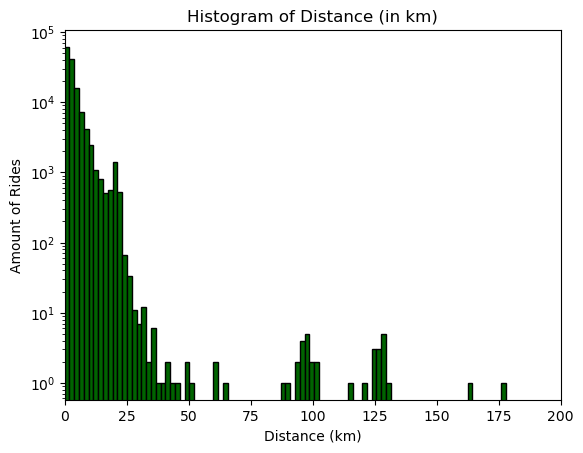

In [14]:
# distance (in km) distribution
plt.hist(
    X_train_uber['distance_km'], 
    color = 'darkgreen', 
    edgecolor = 'black',
    bins = 1000
)
plt.xlim(0,200)
plt.yscale('log')
plt.title('Histogram of Distance (in km)')
plt.xlabel('Distance (km)')
plt.ylabel('Amount of Rides')

In [15]:
# saving X_train and X_test after feature engineering
X_train_uber.to_csv('../../uber-fares-prediction/data/interim/uber_feature_engineering_train_set.csv', index=False)
X_test_uber.to_csv('../../uber-fares-prediction/data/interim/uber_feature_engineering_validation_set.csv', index=False)

## Data Scaling 

The next step is to deal with data scaling. In fact, it is not necessary if we were use only models based on decision trees. However, if we decide to use models based on distances, like KNN and SVM, the scaling is important. Features for latitude and longitude are represented in radians, which have a reasonable range and we will not also modify them. We will apply scaling in `passenger_count`, `distance_km`, `pickup_hour`, `pickup_day`, and `pickup_year` features. 

In [16]:
X_train_uber

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_month,pickup_year,pickup_hour,distance_km
0,-1.291046,0.711458,-1.290793,0.711655,1,28,4,2015,15,1.747231
1,-1.290864,0.711602,-1.291752,0.710376,1,26,3,2012,18,8.907387
2,-1.290621,0.711601,-1.291044,0.711139,1,11,10,2013,8,3.583120
3,-1.291510,0.711240,-1.291464,0.711434,1,20,7,2014,2,1.255360
4,-1.290913,0.711595,-1.291184,0.711514,2,25,11,2014,8,1.402147
...,...,...,...,...,...,...,...,...,...,...
137335,-1.290959,0.711354,-1.290741,0.711509,1,24,4,2015,19,1.441585
137336,-1.291329,0.710239,-1.291743,0.709437,1,16,11,2013,1,5.488365
137337,-1.291118,0.711250,-1.291551,0.710718,5,30,12,2011,19,3.983242
137338,-1.291260,0.711031,-1.291674,0.710409,1,20,11,2011,3,4.440206


In [17]:
# list of featutes to be scaled 
features_to_scale = [
    'passenger_count',
    'pickup_day',
    'pickup_month',
    'pickup_year',
    'pickup_hour',
    'distance_km'
]

In [18]:
# instancing a minmaxscaler object 
scaler = MinMaxScaler()

In [19]:
# scaling our data 
X_train_uber[features_to_scale] = (
    scaler.fit_transform(
        X_train_uber[features_to_scale]
    )
)

X_test_uber[features_to_scale] = (
    scaler.fit_transform(
        X_test_uber[features_to_scale]
    )
)

In [20]:
# saving the data 
X_train_uber.to_csv('../../uber-fares-prediction/data/processed/uber_prepared_train_set.csv', index=False)
X_test_uber.to_csv('../../uber-fares-prediction/data/processed/uber_prepared_validation_set.csv', index=False)